In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [13]:


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
full_dataset = ConcatDataset([train_data, test_data])  # total 60,000 images

full_targets = np.array(train_data.targets + test_data.targets)

indices = np.arange(len(full_dataset))

train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    stratify=full_targets,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=full_targets[temp_idx],
    random_state=42
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 10. Print sizes
print(f"Total dataset size: {len(full_dataset)}")
print(f"Train size: {len(train_dataset)}")   # 42000
print(f"Val size: {len(val_dataset)}")       # 9000
print(f"Test size: {len(test_dataset)}")     # 9000


Total dataset size: 60000
Train size: 42000
Val size: 9000
Test size: 9000


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationNetwork(nn.Module):
    def __init__(self):
        super(ImageClassificationNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # (16 x 16 x 16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2, 2)  # (32 x 8 x 8)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.AvgPool2d(2, 2)  # (64 x 4 x 4)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool4 = nn.AvgPool2d(2, 2)  # (128 x 2 x 2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.AvgPool2d(2, 2)  # (256 x 1 x 1)

        self.fc = nn.Linear(256 * 1 * 1, 10)  # Output for 10 classes

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))

        x = x.view(-1, 256 * 1 * 1)  # Flatten
        x = self.fc(x)
        return x


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': [],
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Training Metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
        train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Validation Metrics
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1: {train_f1:.3f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1: {val_f1:.3f}")

        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

    print("\nTraining complete.")
    return model, history

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1


In [22]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    plt.plot(history[f'train_{metric}'], label='Train')
    plt.plot(history[f'val_{metric}'], label='Validation')
    plt.title(f"{metric.capitalize()} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
model = ImageClassificationNetwork()
model, history = train_model(model, train_loader, val_loader, num_epochs=10)


Epoch [1/10]


Training: 100%|██████████| 657/657 [00:14<00:00, 44.53it/s]


Train Loss: 1.7761, Acc: 33.79%, Precision: 0.333, Recall: 0.338, F1: 0.330
Val   Loss: 1.5257, Acc: 43.59%, Precision: 0.437, Recall: 0.436, F1: 0.426

Epoch [2/10]


Training: 100%|██████████| 657/657 [00:18<00:00, 36.05it/s]


Train Loss: 1.4694, Acc: 45.92%, Precision: 0.453, Recall: 0.459, F1: 0.453
Val   Loss: 1.4316, Acc: 47.33%, Precision: 0.480, Recall: 0.473, F1: 0.453

Epoch [3/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 46.95it/s]


Train Loss: 1.3337, Acc: 51.44%, Precision: 0.508, Recall: 0.514, F1: 0.510
Val   Loss: 1.2881, Acc: 53.81%, Precision: 0.537, Recall: 0.538, F1: 0.530

Epoch [4/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 50.30it/s]


Train Loss: 1.2214, Acc: 55.69%, Precision: 0.552, Recall: 0.557, F1: 0.554
Val   Loss: 1.1821, Acc: 57.18%, Precision: 0.574, Recall: 0.572, F1: 0.567

Epoch [5/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 49.58it/s]


Train Loss: 1.1217, Acc: 59.80%, Precision: 0.594, Recall: 0.598, F1: 0.596
Val   Loss: 1.1262, Acc: 59.48%, Precision: 0.595, Recall: 0.595, F1: 0.585

Epoch [6/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 48.73it/s]


Train Loss: 1.0321, Acc: 63.03%, Precision: 0.627, Recall: 0.630, F1: 0.629
Val   Loss: 1.0560, Acc: 62.56%, Precision: 0.628, Recall: 0.626, F1: 0.618

Epoch [7/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 50.06it/s]


Train Loss: 0.9607, Acc: 65.79%, Precision: 0.655, Recall: 0.658, F1: 0.656
Val   Loss: 1.0022, Acc: 64.58%, Precision: 0.651, Recall: 0.646, F1: 0.641

Epoch [8/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 48.50it/s]


Train Loss: 0.8942, Acc: 68.09%, Precision: 0.679, Recall: 0.681, F1: 0.680
Val   Loss: 0.9779, Acc: 65.87%, Precision: 0.678, Recall: 0.659, F1: 0.660

Epoch [9/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 47.75it/s]


Train Loss: 0.8352, Acc: 70.19%, Precision: 0.700, Recall: 0.702, F1: 0.701
Val   Loss: 0.9221, Acc: 67.92%, Precision: 0.682, Recall: 0.679, F1: 0.680

Epoch [10/10]


Training: 100%|██████████| 657/657 [00:13<00:00, 49.93it/s]


Train Loss: 0.7780, Acc: 72.40%, Precision: 0.722, Recall: 0.724, F1: 0.723
Val   Loss: 0.9111, Acc: 67.96%, Precision: 0.685, Recall: 0.680, F1: 0.678

Training complete.


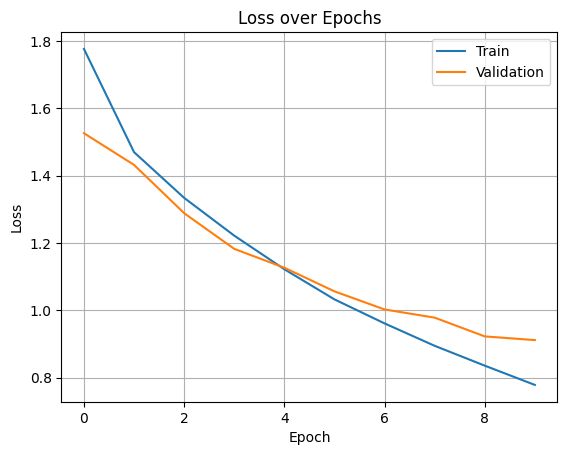

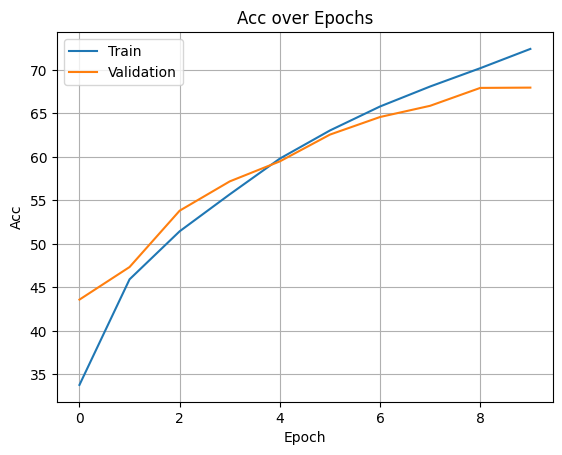

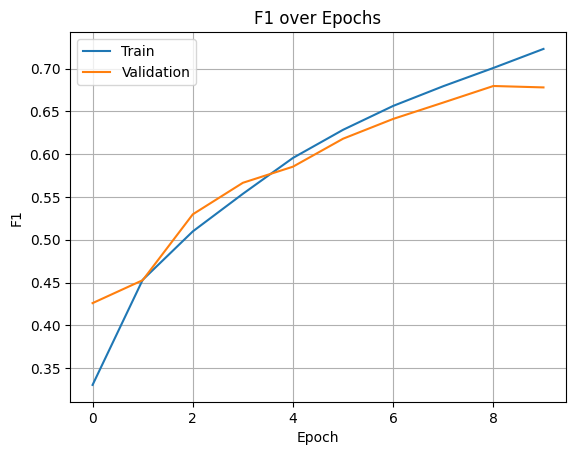

In [24]:
plot_metric(history, 'loss')
plot_metric(history, 'acc')
plot_metric(history, 'f1')

In [25]:
criterion = nn.CrossEntropyLoss()
device="cuda"
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%, Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1: {test_f1:.3f}")



Test Loss: 0.9186, Acc: 67.97%, Precision: 0.689, Recall: 0.680, F1: 0.679


In [26]:
torch.save(model.state_dict(), 'model.pth')